In [1]:
import numpy as np
import numba as nb
import math as mt
import ctypes
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

#Change directory so we can import the rand_point.txt file directly
os.chdir('/Users/samsonmercier/Desktop/PHYS512/problem_sets/ps7')

# Question 1

In [2]:
#Using Prof. Siever's routine to generate random numbers 
#using the C standard library random number generator.

mylib=ctypes.cdll.LoadLibrary("libc.dylib")
rand=mylib.rand
rand.argtypes=[]
rand.restype=ctypes.c_int


@nb.njit
def get_rands_nb(vals):
    n=len(vals)
    for i in range(n):
        vals[i]=rand()
    return vals

def get_rands(n):
    vec=np.empty(n,dtype='int32')
    get_rands_nb(vec)
    return vec


n=300000000
vec=get_rands(n*3)

vv=np.reshape(vec,[n,3])
vmax=np.max(vv,axis=1)

maxval=1e8
vv2=vv[vmax<maxval,:]

f=open('rand_points.txt','w')
for i in range(vv2.shape[0]):
    myline=repr(vv2[i,0])+' '+repr(vv2[i,1])+' '+ repr(vv2[i,2])+'\n'
    f.write(myline)
f.close()

<IPython.core.display.Javascript object>


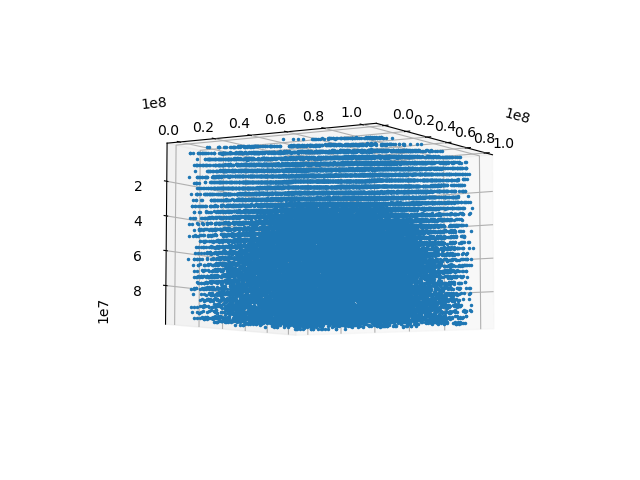

In [12]:
#Getting the (x, y, z) between 0 and 10^8 that we generated in the code above. 
data = np.loadtxt('rand_points.txt')
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

#Plot these points
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(x, y, z, '.', markersize = 3)
plt.show()

#After playing around with the view settings, we can see that the points indeed lie on a set of ~30 planes.

In [4]:
#Generate the same number of random (x, y, z) points using the Python random number
#generator function np.random.randint. 
#We chose to use this function since we can choose on what range we want to generate the numbers. 
#Using this method, we can directly get numbers between 0 and 10^8.

#Getting number of (x, y, z) triples found in rand_points.txt
n=len(x)

#Making lists for the x, y, and z coordinates of our random numbers
newx = []
newy = []
newz = []

#Using a for loop over n to generate and append random numbers to each x, y, and z list.
for i in range(n):
    newx.append(np.random.randint(0, 1e8))
    newy.append(np.random.randint(0, 1e8))
    newz.append(np.random.randint(0, 1e8))

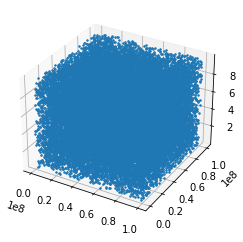

In [5]:
plt.close(fig)

#Plotting the points we generated with the Python random number generator. 
fig2 = plt.figure()
ax2 = plt.axes(projection='3d')
ax2.plot(newx, newy, newz, '.', markersize = 3)
plt.show()

#Playing around with the view settings, we can see no discernible patterns in the 
#spatial distribution of the points. 

# Question 2 - Getting Exponential Deviates from a Lorentzian PDF

<ipython-input-6-c172415c408c>:24: RuntimeWarning: overflow encountered in exp
  accept = y < np.exp(-t)


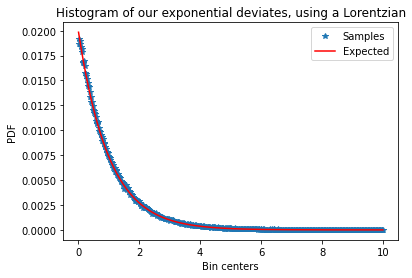

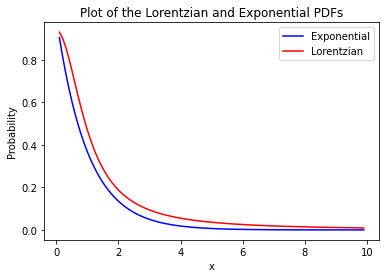

Method is 83.85770000000001% Efficient


In [6]:
#From our calculations in-class we know that the CDF of a Lorentzian distribution is CDF=arctan(t). 
#Using this knowledge, and our randomly generated numbers we can generate the x coordinates of a Lorentzian
#distribution using CDF=q <=> arctan(t)=q <=> t = arctan(q).

def lorentzians(n):
    #Shifting the randomly generated number so they're over the range -pi/2 to pi/2.
    #This is necessary because the tan function only takes numbers between -pi/2 and pi/2 as input.
    q=np.pi*(np.random.rand(n)-1)
    return np.tan(q)

#N corresponds to the amount of random numbers we want to generate.
N = 1000000
#Creating a scaling factor that we will use to bring our Lorentzian slightly closer to 
#the exponential distribution we are trying to make. Using this scaling factor can help us
#make our method a little more efficient. 
M = 0.94

#Generate Lorenzian x coordinates.
t=lorentzians(N)
#Generate random numbers along the Lorentzian (without forgetting to add the scaling factor) .
y = 1/(1+t**2)*np.random.rand(N)*M

#Accepting only the values that lie under the exponential distribution we are trying to simulate.
accept = y < np.exp(-t)
exp_val = t[accept]

#Making a histogram of our deviates.
bins=np.linspace(0,10,500)
aa, bb = np.histogram(exp_val, bins)
aa=aa/aa.sum()

#Making the x coordinates for our plotting.
cents=0.5*(bins[1:]+bins[:-1])
pred = np.exp(-cents)
pred=pred/pred.sum()

#Plotting
fig, ax1=plt.subplots()
ax1.plot(cents, aa, '*', label='Samples')
ax1.plot(cents, pred, 'r', label='Expected')
plt.xlabel('Bin centers')
plt.ylabel('PDF')
plt.title('Histogram of our exponential deviates, using a Lorentzian')
plt.legend()
plt.show()

#Plotting the PDFs of our exponential and Lorentzian distributions.
#This is useful to make sure that the Lorentzian is always over the exponential
#when we play around with the scaling factor. 
#Generating x coordinates and y coordinates for our two distributions. 
X=np.arange(0.1, 10, 0.1)
expo = np.exp(-X)
Lorentz = 1/(1+X**2)*M

plt.plot(X, expo, 'b', label='Exponential')
plt.plot(X, Lorentz, 'r', label='Lorentzian')
plt.title('Plot of the Lorentzian and Exponential PDFs')
plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()
plt.show()

#Printing the efficiency of our method.
print(f"Method is {len(exp_val)/(len(t)) * 100}% Efficient")

# Question 2 - Getting Exponential Deviates from a Power Law PDF

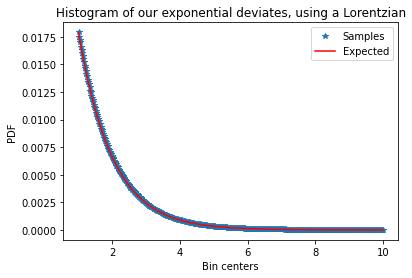

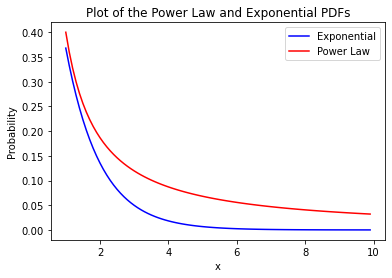

Method is 9.192734% Efficient


In [7]:
#From our calculations in-class we know that the CDF of a Power Law distribution is CDF=t^(1-alpha). 
#Using this knowledge, and our randomly generated numbers we can generate the x coordinates of a Power Law
#distribution using CDF=q <=> t^(1-alpha)=q <=> t = q^(1/(1-alpha))

def power(alpha, n):
    #We don't need to rescale our q's because the power law takes 
    #any number from -np.inf to +np.inf.
    q=np.random.rand(n)
    return q**(1/(1-alpha))

#N corresponds to the amount of random numbers we want to generate.
N = 100000000
#Creating a scaling factor that we will use to bring our Lorentzian slightly closer to 
#the exponential distribution we are trying to make. Using this scaling factor can help us
#make our method a little more efficient. 
M = 0.4
#a represents the power we use for our Power Law. It was referred to as alpha during lectures.
a = 1.1

#Generate Power Law x coordinates.
t=power(a, N)
#Generate random numbers along the Power Law(without forgetting to add the scaling factor).
y = (t**(-a))*np.random.rand(N)*M

#Accepting only the values that lie under the exponential distribution we are trying to simulate.
accept = y < np.exp(-t)
exp_val = t[accept]

#Making a histogram of our deviates.
bins=np.linspace(1,10,500)
aa, bb = np.histogram(exp_val, bins)
aa=aa/aa.sum()

#Making the x coordinates for our plotting.
cents=0.5*(bins[1:]+bins[:-1])
pred = np.exp(-cents)
pred=pred/pred.sum()

#Plotting
plt.plot(cents, aa, '*', label='Samples')
plt.plot(cents, pred, 'r', label='Expected')
plt.legend()
plt.xlabel('Bin centers')
plt.ylabel('PDF')
plt.title('Histogram of our exponential deviates, using a Lorentzian')
plt.show()


#Plotting the PDFs of our exponential and Power Law distributions.
#This is useful to make sure that the Power Law is always over the exponential
#when we play around with the scaling factor. 
#Generating x coordinates and y coordinates for our two distributions. 
X=np.arange(1, 10, 0.1)
expo = np.exp(-X)
Power = X**(-a)*M
plt.plot(X, expo, 'b', label='Exponential')
plt.plot(X, Power, 'r', label='Power Law')
plt.title('Plot of the Power Law and Exponential PDFs')
plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()
plt.show()

#Printing the efficiency of our method.
print(f"Method is {len(exp_val)/(len(t)) * 100}% Efficient")

# Question 3

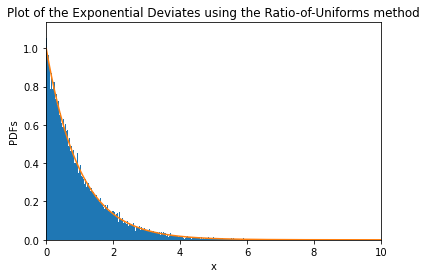

Method is 67.9673% Efficient


In [11]:
#Number of random points we generate.
N=1000000

# Calculated Bounds(see scanned pdf).
umax = 1
vmax = 2/np.e

# Generate the random numbers
u=np.random.uniform(low=0,high=umax,size=N)
v=np.random.uniform(low=0,high=vmax,size=N)

# Do the rejection step
keep = u < np.sqrt(np.exp(-(v/u))) 
rand_exp = v[keep]/u[keep]

# Plot Results
plt.plot()
# Cut far numbers to get a better plot.
plt.hist(rand_exp[np.abs(rand_exp)<100],bins=10000,density=True)
xs = np.linspace(0,10,1000)

#Plotting
plt.plot(xs,np.exp(-xs))
plt.title('Plot of the Exponential Deviates using the Ratio-of-Uniforms method')
plt.ylabel('PDFs')
plt.xlabel('x')
plt.xlim(min(xs),max(xs))
plt.show()

#Printing the efficiency of our method.
print(f"Method is {len(rand_exp)/(len(u)) * 100}% Efficient")

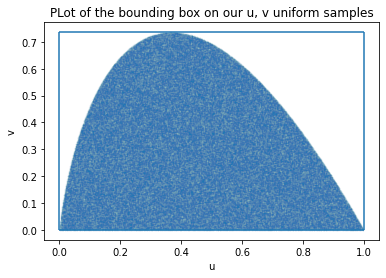

In [9]:
# Plot bounding box and uniform samples
plt.scatter(u[keep],v[keep],alpha=0.03,s=0.4)
plt.vlines([0,umax],ymin=0,ymax=vmax)
plt.hlines([0,vmax],xmin=0,xmax=umax)
plt.xlabel('u')
plt.ylabel('v')
plt.title('PLot of the bounding box on our u, v uniform samples')
plt.show()